# Importing Important Libraries

### Installing Tensorflow Addons

In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.6 MB/s eta 0:00:00


### Importing The Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

# Loading the CDB (Cat-Dog-Bird) Dataset and the Labels

## The Training Set

In [3]:
img = np.zeros((3, 8, 8, 1), dtype = "uint8")

In [4]:
img[0][..., 0] = np.array([[ 69,  72,  70,  72,  71,  70,  70,  69],
                              [ 63,  96,  71,  70,  71,  70,  69,  68],
                              [ 44, 158,  37,  34,  38,  41,  37,  39],
                              [ 37,  52, 165, 106,  54, 131,  35,  34],
                              [ 38,  41, 178, 181, 181, 167,  63,  33],
                              [ 77,  79, 167, 160, 169,  43,  77,  76],
                              [ 86, 113, 134,  55, 157,  85,  87,  85],
                              [ 88,  97, 110,  91, 127, 120,  95,  94]])
img[1][..., 0] = np.array([[157, 162, 152, 167, 168, 157, 148, 136],
                              [138, 157, 136, 137, 123, 128, 126, 119],
                              [135, 128,  87,  59, 101, 112, 123, 137],
                              [123, 128,  99,  22,  70, 113, 107, 106],
                              [115, 116, 167,  29,  31,  57, 112, 122],
                              [ 90,  93, 113, 136,  91,  35,  58,  87],
                              [112, 116, 123, 111, 108,  89, 105, 116],
                              [137, 129, 132, 128, 127, 112, 112, 132]])
img[2][..., 0] = np.array([[ 38,  33, 211, 233, 235, 234, 234, 233],
                              [195,   8,  83, 153, 235, 234, 228, 237],
                              [235, 161,  12,  72, 233, 227, 235, 195],
                              [235, 232,   9, 104, 127, 216, 221, 226],
                              [238, 234,  87, 197, 118, 130, 222, 202],
                              [216,  93, 183, 147,  18,  54, 191, 217],
                              [237, 198, 134, 219, 206,  14, 134, 228],
                              [233, 215, 196, 221, 214, 201,  24, 229]])

In [5]:
y = np.array([0, 1, 2], dtype = "uint8")

## Creating Labels to Show with Output

In [6]:
labels = ['Cat', 'Dog', 'Bird']

# The 3 Training Matrices


Printing Cat: 
[[ 69  72  70  72  71  70  70  69]
 [ 63  96  71  70  71  70  69  68]
 [ 44 158  37  34  38  41  37  39]
 [ 37  52 165 106  54 131  35  34]
 [ 38  41 178 181 181 167  63  33]
 [ 77  79 167 160 169  43  77  76]
 [ 86 113 134  55 157  85  87  85]
 [ 88  97 110  91 127 120  95  94]]

Printing Dog: 
[[157 162 152 167 168 157 148 136]
 [138 157 136 137 123 128 126 119]
 [135 128  87  59 101 112 123 137]
 [123 128  99  22  70 113 107 106]
 [115 116 167  29  31  57 112 122]
 [ 90  93 113 136  91  35  58  87]
 [112 116 123 111 108  89 105 116]
 [137 129 132 128 127 112 112 132]]

Printing Bird: 
[[ 38  33 211 233 235 234 234 233]
 [195   8  83 153 235 234 228 237]
 [235 161  12  72 233 227 235 195]
 [235 232   9 104 127 216 221 226]
 [238 234  87 197 118 130 222 202]
 [216  93 183 147  18  54 191 217]
 [237 198 134 219 206  14 134 228]
 [233 215 196 221 214 201  24 229]]


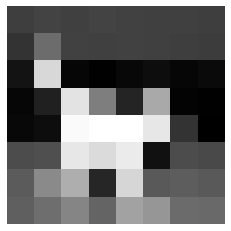

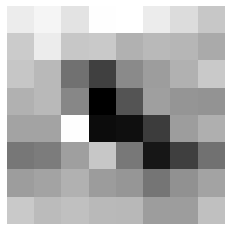

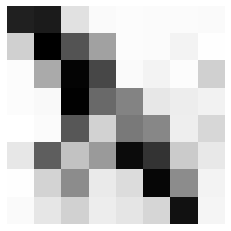

In [7]:
for i in y:
    plt.figure(figsize=(4, 4))
    image = img[i][..., 0]
    plt.title(labels[i])
    plt.imshow(image, cmap='gray')
    plt.axis("off")
    print(f'\nPrinting {labels[i]}: \n{image}')

# Initializing Hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 5#10#0
image_size = 8
patch_size = 4
num_patches = (image_size // patch_size) ** 2
projection_dim = 4#3#16#64
num_heads = 4 # 4 different parameterizaiton of the query, key and value matrices
              # we have 4 separate transformations that then aggregate outputs
              # of these four separate self-attention parameterizations from
              # the previous layer
              # e.g. from layer l to layer l+1 with these self-attention layers

transformer_units = [projection_dim * 2, projection_dim] # size of the transformer layer(s)
transformer_layers = 1#2#4#8
mlp_head_units = [4, 2]#[128, 64]#[2048, 1024] #size of the dense layers of the final classifiers

num_train_images = img.shape[0]

# Patch Maker

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
    
    #@tf.function
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1
                   ],
            strides=[1, self.patch_size, self.patch_size, 1
                     ],
            rates=[1, 1, 1, 1
                   ],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        tf.print("\nThe patches:\n\nOriginal Form\n", patches, summarize = -1)
        for i in range(len(patches)):
          tf.print("\nImage", i+1)
          for j in range(len(patches[0])):
            tf.print("Patch", j+1)
            tf.print(patches[i, j#, 0:49:3
                             ], summarize = -1)
        return patches

In [ ]:
patches = Patches(patch_size)(img)
#print(patches.shape)
n = int(np.sqrt(patches.shape[1]))


The patches:

Original Form
 [[[69 72 70 72 63 96 71 70 44 158 37 34 37 52 165 106]
  [71 70 70 69 71 70 69 68 38 41 37 39 54 131 35 34]
  [38 41 178 181 77 79 167 160 86 113 134 55 88 97 110 91]
  [181 167 63 33 169 43 77 76 157 85 87 85 127 120 95 94]]

 [[157 162 152 167 138 157 136 137 135 128 87 59 123 128 99 22]
  [168 157 148 136 123 128 126 119 101 112 123 137 70 113 107 106]
  [115 116 167 29 90 93 113 136 112 116 123 111 137 129 132 128]
  [31 57 112 122 91 35 58 87 108 89 105 116 127 112 112 132]]

 [[38 33 211 233 195 8 83 153 235 161 12 72 235 232 9 104]
  [235 234 234 233 235 234 228 237 233 227 235 195 127 216 221 226]
  [238 234 87 197 216 93 183 147 237 198 134 219 233 215 196 221]
  [118 130 222 202 18 54 191 217 206 14 134 228 214 201 24 229]]]

Image 1
Patch 1
[69 72 70 72 63 96 71 70 44 158 37 34 37 52 165 106]
Patch 2
[71 70 70 69 71 70 69 68 38 41 37 39 54 131 35 34]
Patch 3
[38 41 178 181 77 79 167 160 86 113 134 55 88 97 110 91]
Patch 4
[181 167 63 33 169 43 7

## Patch Testing

In [ ]:
print(type(patches))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
tf.print("The Patches:\n", patches, summarize = -1)

The Patches:
 [[[69 72 63 96]
  [70 72 71 70]
  [71 70 71 70]
  [70 69 69 68]
  [44 158 37 52]
  [37 34 165 106]
  [38 41 54 131]
  [37 39 35 34]
  [38 41 77 79]
  [178 181 167 160]
  [181 167 169 43]
  [63 33 77 76]
  [86 113 88 97]
  [134 55 110 91]
  [157 85 127 120]
  [87 85 95 94]]

 [[157 162 138 157]
  [152 167 136 137]
  [168 157 123 128]
  [148 136 126 119]
  [135 128 123 128]
  [87 59 99 22]
  [101 112 70 113]
  [123 137 107 106]
  [115 116 90 93]
  [167 29 113 136]
  [31 57 91 35]
  [112 122 58 87]
  [112 116 137 129]
  [123 111 132 128]
  [108 89 127 112]
  [105 116 112 132]]

 [[38 33 195 8]
  [211 233 83 153]
  [235 234 235 234]
  [234 233 228 237]
  [235 161 235 232]
  [12 72 9 104]
  [233 227 127 216]
  [235 195 221 226]
  [238 234 216 93]
  [87 197 183 147]
  [118 130 18 54]
  [222 202 191 217]
  [237 198 233 215]
  [134 219 196 221]
  [206 14 214 201]
  [134 228 24 229]]]


In [ ]:
print(patches.shape)

(3, 16, 4)


### Cat Image Patches


Original Patch 1:
[ 69  72  70  72  63  96  71  70  44 158  37  34  37  52 165 106]

Patch 1 (Reshaped to Show as Image):
[[ 69  72  70  72]
 [ 63  96  71  70]
 [ 44 158  37  34]
 [ 37  52 165 106]]

Original Patch 2:
[ 71  70  70  69  71  70  69  68  38  41  37  39  54 131  35  34]

Patch 2 (Reshaped to Show as Image):
[[ 71  70  70  69]
 [ 71  70  69  68]
 [ 38  41  37  39]
 [ 54 131  35  34]]

Original Patch 3:
[ 38  41 178 181  77  79 167 160  86 113 134  55  88  97 110  91]

Patch 3 (Reshaped to Show as Image):
[[ 38  41 178 181]
 [ 77  79 167 160]
 [ 86 113 134  55]
 [ 88  97 110  91]]

Original Patch 4:
[181 167  63  33 169  43  77  76 157  85  87  85 127 120  95  94]

Patch 4 (Reshaped to Show as Image):
[[181 167  63  33]
 [169  43  77  76]
 [157  85  87  85]
 [127 120  95  94]]


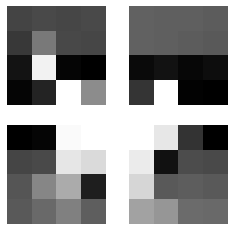

In [ ]:
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size))
    plt.imshow(patch_img.numpy().astype("uint8"), cmap = "gray")
    plt.axis("off")
    print(f"\nOriginal Patch {i+1}:\n{patch}")#[..., 0:48:3]}")
    print(f'\nPatch {i+1} (Reshaped to Show as Image):\n{patch_img.numpy()}')

### Dog Image Patches


Original Patch 1:
[157 162 138 157]

Patch 1 (Reshaped to Show as Image):
[157 138]

Original Patch 2:
[152 167 136 137]

Patch 2 (Reshaped to Show as Image):
[152 136]

Original Patch 3:
[168 157 123 128]

Patch 3 (Reshaped to Show as Image):
[168 123]

Original Patch 4:
[148 136 126 119]

Patch 4 (Reshaped to Show as Image):
[148 126]

Original Patch 5:
[135 128 123 128]

Patch 5 (Reshaped to Show as Image):
[135 123]

Original Patch 6:
[87 59 99 22]

Patch 6 (Reshaped to Show as Image):
[87 99]

Original Patch 7:
[101 112  70 113]

Patch 7 (Reshaped to Show as Image):
[101  70]

Original Patch 8:
[123 137 107 106]

Patch 8 (Reshaped to Show as Image):
[123 107]

Original Patch 9:
[115 116  90  93]

Patch 9 (Reshaped to Show as Image):
[115  90]

Original Patch 10:
[167  29 113 136]

Patch 10 (Reshaped to Show as Image):
[167 113]

Original Patch 11:
[31 57 91 35]

Patch 11 (Reshaped to Show as Image):
[31 91]

Original Patch 12:
[112 122  58  87]

Patch 12 (Reshaped to Show as Imag

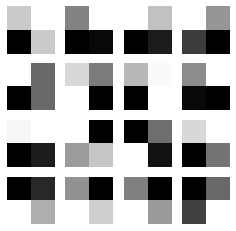

In [ ]:
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[1]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size))
    plt.imshow(patch_img.numpy().astype("uint8"), cmap = "gray")
    plt.axis("off")
    print(f"\nOriginal Patch {i+1}:\n{patch}")#[..., 0:48:3]}")
    print(f'\nPatch {i+1} (Reshaped to Show as Image):\n{patch_img[..., 0].numpy()}')

### Bird Image Patches


Original Patch 1:
[ 38  33 195   8]

Patch 1 (Reshaped to Show as Image):
[ 38 195]

Original Patch 2:
[211 233  83 153]

Patch 2 (Reshaped to Show as Image):
[211  83]

Original Patch 3:
[235 234 235 234]

Patch 3 (Reshaped to Show as Image):
[235 235]

Original Patch 4:
[234 233 228 237]

Patch 4 (Reshaped to Show as Image):
[234 228]

Original Patch 5:
[235 161 235 232]

Patch 5 (Reshaped to Show as Image):
[235 235]

Original Patch 6:
[ 12  72   9 104]

Patch 6 (Reshaped to Show as Image):
[12  9]

Original Patch 7:
[233 227 127 216]

Patch 7 (Reshaped to Show as Image):
[233 127]

Original Patch 8:
[235 195 221 226]

Patch 8 (Reshaped to Show as Image):
[235 221]

Original Patch 9:
[238 234 216  93]

Patch 9 (Reshaped to Show as Image):
[238 216]

Original Patch 10:
[ 87 197 183 147]

Patch 10 (Reshaped to Show as Image):
[ 87 183]

Original Patch 11:
[118 130  18  54]

Patch 11 (Reshaped to Show as Image):
[118  18]

Original Patch 12:
[222 202 191 217]

Patch 12 (Reshaped to Sh

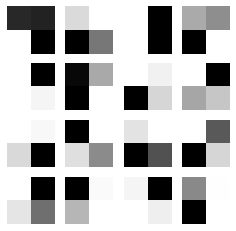

In [ ]:
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[2]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size))
    plt.imshow(patch_img.numpy().astype("uint8"), cmap = "gray")
    plt.axis("off")
    print(f"\nOriginal Patch {i+1}:\n{patch}")#[..., 0:48:3]}")
    print(f'\nPatch {i+1} (Reshaped to Show as Image):\n{patch_img[..., 0].numpy()}')

In [ ]:
tf.shape(patches)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 3, 16,  4], dtype=int32)>

# Patch Encoder

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
 
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        #print("\n1st Dense Layer Type:", type(self.projection))
        tf.print("\nPatch Positions:", positions, "\n")

        projection = self.projection(patch)
        position_embedding = self.position_embedding(positions)
        encoded = projection + position_embedding

        tf.print("Config of Dense Layer:\n",self.projection.get_config())
        tf.print("\nWeights of Dense Layer:\n",self.projection.kernel#get_weights()
        , summarize = -1)
        tf.print("\nBiases of Dense Layer:\n",self.projection.bias#get_weights()
        , summarize = -1)
        tf.print("\nConfig of Embedded Layer:\n",self.position_embedding.get_config())
        tf.print("\nShape of patch: ",patch.shape)
        tf.print("\nWeights of Embedding Layer:\n",self.position_embedding.weights#get_weights()
        , summarize = -1)
        tf.print("\nAfter Applying projection (layers.Dense) on patches:\n------\n", projection, summarize = -1)
        tf.print("\nProjection Shape: ",projection.shape)
        tf.print("\n\nAfter Applying position_embedding (layers.Embedding) on the patch positions:\n------\n", position_embedding, summarize = -1)
        tf.print("\nPosition Encoding Shape: ",position_embedding.shape)
        tf.print("\n\nEncoded Patches got After Adding Positional Encoding with Projected Patches:\n------\n", encoded, "\n", summarize = -1)

        return encoded

In [ ]:
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)


Patch Positions: [0 1 2 3] 

Config of Dense Layer:
 {'activation': 'linear',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'dtype': 'float32',
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'GlorotUniform',
                        'config': {'seed': None}},
 'kernel_regularizer': None,
 'name': 'dense',
 'trainable': True,
 'units': 4,
 'use_bias': True}

Weights of Dense Layer:
 [[0.197664559 -0.0223491192 0.361763895 0.165034831]
 [-0.17457974 -0.0926364958 -0.432368875 0.31753695]
 [-0.227721035 0.511412621 0.0260567069 -0.0786447227]
 [0.32193321 -0.435569942 -0.424730539 -0.386253953]
 [-0.233112186 0.502953172 -0.136952847 0.376873851]
 [0.253313243 -0.116271347 0.259633839 0.0554732084]
 [0.366308689 0.00624454 -0.347043931 -0.152876526]
 [0.0748854876 -0.240468442 -0.32480076 -0.196881562]
 [-0.464053392 0.37191987 0.517256 0.360119522]
 [0.0195466876 -0.23083

# Inside Transformer Encoder

## Layer Normalization

### Mathematical Definition of Layer Normalization

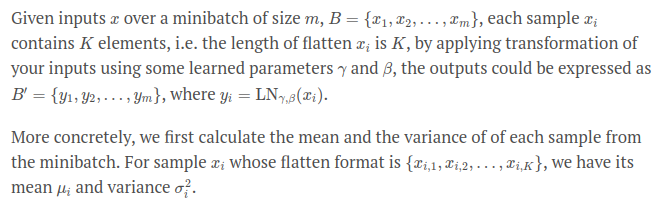

Equation of Mean and Variance:

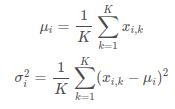

Equation for Normalizing Each Sample:

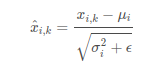

Finally, the Equation for Scaling and Shifting Step:

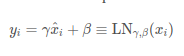

(Credit: https://leimao.github.io/blog/Layer-Normalization/)

In [ ]:
ln = layers.LayerNormalization(epsilon=1e-6)
ln.get_config()

{'name': 'layer_normalization',
 'trainable': True,
 'dtype': 'float32',
 'axis': -1,
 'epsilon': 1e-06,
 'center': True,
 'scale': True,
 'beta_initializer': {'class_name': 'Zeros', 'config': {}},
 'gamma_initializer': {'class_name': 'Ones', 'config': {}},
 'beta_regularizer': None,
 'gamma_regularizer': None,
 'beta_constraint': None,
 'gamma_constraint': None}

In [ ]:
tf.print(encoded_patches, summarize = -1)

[[[58.4535713 19.0668411 -125.882301 102.108047]
  [-21.4472504 55.0068779 -13.7809982 53.9500198]
  [33.8963966 31.1790409 -151.917542 63.1304245]
  [-123.320183 159.230972 22.3097782 254.930176]]

 [[-0.890841126 90.6056061 -80.8556442 154.286728]
  [-28.5312405 42.2529564 -81.6595688 205.707672]
  [-83.9119568 133.212906 -22.659277 200.364929]
  [-93.6637192 89.3141479 -39.8554726 136.597961]]

 [[-237.582672 263.055908 21.0905342 93.1777573]
  [-51.9894753 94.1006775 -149.826843 366.337738]
  [-142.648972 151.257812 -60.5100174 347.125519]
  [-208.192139 106.200279 40.0646896 130.457581]]]


In [ ]:
bird_patch_1 = encoded_patches[2,0]
tf.print(bird_patch_1, summarize = -1)

[-237.582672 263.055908 21.0905342 93.1777573]


In [ ]:
(mean, variance) = tf.nn.moments(bird_patch_1, [0])
tf.print("mean =",mean, "\nvariance =", variance)

mean = 34.9353828 
variance = 32472.2305


In [ ]:
epsilon = 1e-6
bird_patch_1 = (bird_patch_1 - mean)/tf.math.sqrt(variance + epsilon)
tf.print(bird_patch_1)

[-1.51230443 1.265926 -0.0768302307 0.32320866]


In [ ]:
x1 = ln(encoded_patches)
tf.print("\nAfter Applying Layer Normalization:\n", x1, summarize = -1)


After Applying Layer Normalization:
 [[[0.525710046 0.0657508075 -1.6269691 1.03550816]
  [-1.10316563 1.01174927 -0.891097724 0.982513964]
  [0.467351 0.435461938 -1.71323454 0.810421586]
  [-1.41211152 0.566946864 -0.392083168 1.23724794]]

 [[-0.466710389 0.557884336 -1.36217153 1.27099776]
  [-0.581954956 0.0721786916 -1.07292652 1.58270264]
  [-1.2270714 0.667005658 -0.692737 1.25280273]
  [-1.25068331 0.709264874 -0.674321949 1.21574056]]

 [[-1.51230431 1.26592588 -0.0768302307 0.32320869]
  [-0.599386692 0.151305526 -1.10212934 1.5502106]
  [-1.1345489 0.405963123 -0.704017639 1.43260336]
  [-1.67862391 0.66353631 0.170839429 0.844248295]]]


In [ ]:
x1.shape

TensorShape([3, 4, 4])

## Mutihead Attention

In [ ]:
mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)
mha.get_config()

{'name': 'multi_head_attention',
 'trainable': True,
 'dtype': 'float32',
 'num_heads': 4,
 'key_dim': 4,
 'value_dim': 4,
 'dropout': 0.1,
 'use_bias': True,
 'output_shape': None,
 'attention_axes': None,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None,
 'query_shape': None,
 'key_shape': None,
 'value_shape': None}

In [ ]:
attention_output = mha(x1, x1) # self-attention

In [ ]:
tf.print("\nAfter Applying Multi Head Attention:\n", attention_output, summarize = -1)


After Applying Multi Head Attention:
 [[[-0.211165577 -0.845963299 -0.610393882 0.174562782]
  [-0.215460986 -0.844219446 -0.600763261 0.150403067]
  [-0.208940834 -0.836072862 -0.605518341 0.166665852]
  [-0.221418023 -0.861829638 -0.605720699 0.158783525]]

 [[-0.345288515 -0.793333888 -0.565604389 0.0899213552]
  [-0.347224891 -0.796803117 -0.567548335 0.0926812291]
  [-0.347723842 -0.794607639 -0.565518081 0.0891950727]
  [-0.347665042 -0.794445395 -0.565326214 0.0889871716]]

 [[-0.36403802 -0.345643342 -0.292672634 -0.130869329]
  [-0.364237875 -0.344210893 -0.30732432 -0.123007208]
  [-0.367340237 -0.341668189 -0.304339111 -0.126928687]
  [-0.370315343 -0.352931082 -0.299222708 -0.123157352]]]


In [ ]:
attention_output.shape

TensorShape([3, 4, 4])

## Adding Attention Output with Encoded Patches

layers.Add() is a layer that performs element by element addition between 2 or more input matrices of same dimension.

In [ ]:
x2 = layers.Add()([attention_output, encoded_patches])

In [ ]:
tf.print(attention_output, summarize = -1)

[[[-0.211165577 -0.845963299 -0.610393882 0.174562782]
  [-0.215460986 -0.844219446 -0.600763261 0.150403067]
  [-0.208940834 -0.836072862 -0.605518341 0.166665852]
  [-0.221418023 -0.861829638 -0.605720699 0.158783525]]

 [[-0.345288515 -0.793333888 -0.565604389 0.0899213552]
  [-0.347224891 -0.796803117 -0.567548335 0.0926812291]
  [-0.347723842 -0.794607639 -0.565518081 0.0891950727]
  [-0.347665042 -0.794445395 -0.565326214 0.0889871716]]

 [[-0.36403802 -0.345643342 -0.292672634 -0.130869329]
  [-0.364237875 -0.344210893 -0.30732432 -0.123007208]
  [-0.367340237 -0.341668189 -0.304339111 -0.126928687]
  [-0.370315343 -0.352931082 -0.299222708 -0.123157352]]]


In [ ]:
tf.print(encoded_patches, summarize = -1)

[[[58.4535713 19.0668411 -125.882301 102.108047]
  [-21.4472504 55.0068779 -13.7809982 53.9500198]
  [33.8963966 31.1790409 -151.917542 63.1304245]
  [-123.320183 159.230972 22.3097782 254.930176]]

 [[-0.890841126 90.6056061 -80.8556442 154.286728]
  [-28.5312405 42.2529564 -81.6595688 205.707672]
  [-83.9119568 133.212906 -22.659277 200.364929]
  [-93.6637192 89.3141479 -39.8554726 136.597961]]

 [[-237.582672 263.055908 21.0905342 93.1777573]
  [-51.9894753 94.1006775 -149.826843 366.337738]
  [-142.648972 151.257812 -60.5100174 347.125519]
  [-208.192139 106.200279 40.0646896 130.457581]]]


In [ ]:
tf.print("\nAfter Adding Attention Output with Encoded Patches:\n", x2, summarize = -1)


After Adding Attention Output with Encoded Patches:
 [[[58.2424049 18.2208786 -126.492699 102.282608]
  [-21.6627121 54.1626587 -14.3817616 54.1004219]
  [33.6874542 30.342968 -152.523056 63.2970886]
  [-123.541603 158.369141 21.7040577 255.088959]]

 [[-1.23612964 89.8122711 -81.4212494 154.376648]
  [-28.8784657 41.4561539 -82.2271194 205.800354]
  [-84.2596817 132.418304 -23.2247944 200.454117]
  [-94.0113831 88.5197 -40.4208 136.686951]]

 [[-237.946716 262.710266 20.7978611 93.0468903]
  [-52.353714 93.7564697 -150.134171 366.214722]
  [-143.016312 150.916138 -60.8143578 346.998596]
  [-208.562454 105.847351 39.7654686 130.334427]]]


## Layer Normalization Again

In [ ]:
x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
tfp = True

In [ ]:
tf.print("\nAfter Applying LayerNormalization2:\n", x3, summarize = -1)


After Applying LayerNormalization2:
 [[[0.526052713 0.0600533932 -1.62495053 1.03884447]
  [-1.09811664 0.998324215 -0.896810949 0.996603429]
  [0.468272299 0.429105669 -1.71240294 0.815025032]
  [-1.41034079 0.563333333 -0.393467128 1.24047446]]

 [[-0.465269446 0.552583456 -1.36167908 1.27436495]
  [-0.580215514 0.0684129596 -1.07219875 1.5840013]
  [-1.2255007 0.663023114 -0.693532348 1.25601017]
  [-1.24885976 0.704404652 -0.675387084 1.2198422]]

 [[-1.51255679 1.26541638 -0.0768722743 0.324012697]
  [-0.599553406 0.150938779 -1.10180092 1.55041552]
  [-1.13451838 0.405501366 -0.703832269 1.43284917]
  [-1.67852235 0.662753701 0.170670047 0.845098495]]]


## MLP Network

## The First Dense Layer in MLP
The activation function used here is GELU (Gaussian Error Linear Unit)

In [ ]:
GeluDense = layers.Dense(units = 8, activation = tf.nn.gelu)

In [ ]:
x3_1 = GeluDense(x3)

### The weights and biases of the dense layer:

In [ ]:
tf.print("Weights of MLP Dense layer with 8 units:\n", GeluDense.kernel, "\n\nBiases of MLP Dense layer with 8 units:\n", GeluDense.bias, summarize = -1)

Weights of MLP Dense layer with 8 units:
 [[0.161840022 -0.31939134 -0.0046017766 -0.626717746 -0.589531064 -0.543903232 -0.682500601 -0.567107737]
 [-0.0139148831 -0.461423188 -0.137415767 0.105289042 0.292294621 -0.392546296 -0.587241113 0.104345143]
 [0.220772266 0.569501 0.0865269899 -0.423274219 -0.376148134 0.262416899 -0.36244148 0.448165]
 [-0.385241061 -0.687597513 -0.695370555 -0.0489490032 0.506759 0.0494766831 -0.515810668 0.0631870627]] 

Biases of MLP Dense layer with 8 units:
 [0 0 0 0 0 0 0 0]


### Calculating net input for verification.

In [ ]:
net_inp = tf.tensordot(x3, GeluDense.kernel, 1)

In [ ]:
tf.print(net_inp, summarize = -1)

[[[-0.674648821 -1.83544457 -0.873657 0.313585639 0.84509474 -0.684711456 -0.341194689 -0.954666674]
  [-0.773534358 -1.30591774 -0.902739227 1.12413597 1.78155017 0.0193509758 -0.0258089304 0.387973905]
  [-0.622217953 -1.88318586 -0.776034236 0.436626941 0.906502664 -0.832177401 -0.371337384 -0.936725736]
  [-0.800836623 -0.886511564 -0.967555761 1.04902291 1.77272248 0.5040766 0.134504795 0.76064]]

 [[-0.874547 -1.75809956 -1.07777047 0.863758385 1.59379697 -0.258129269 -0.170755148 -0.208216235]
  [-0.941788077 -1.54602504 -1.20097303 0.747133315 1.56806421 0.0857338905 -0.0726129413 -0.0442502946]
  [-0.844540358 -1.1731168 -1.01887214 1.06992602 1.81363416 0.286435127 0.0505520105 0.532720864]
  [-0.830957234 -1.1495477 -0.997730911 1.08301258 1.81434691 0.285868227 0.0542728901 0.556132615]]

 [[-0.404194593 -0.367364049 -0.398888111 1.09785867 1.45468533 0.321808517 0.149948955 0.975844622]
  [-0.939662814 -1.57169294 -1.19143116 0.782115579 1.59770131 0.0544268191 -0.07982438

### Output of 1st Dense Layer

Manual Output

In [ ]:
output = net_inp*.5*(1+tf.math.erf(net_inp/(2**.5)))

In [ ]:
tf.print(output, summarize = -1)

[[[-0.168628082 -0.0609732904 -0.167001784 0.195389599 0.676896393 -0.16896145 -0.125040516 -0.162172198]
  [-0.16987054 -0.125094205 -0.165501118 0.977461338 1.7149 0.00982486736 -0.0126387589 0.252564162]
  [-0.166069508 -0.0561897047 -0.169846252 0.292020053 0.741215587 -0.168644398 -0.131896496 -0.163411617]
  [-0.169467539 -0.166372463 -0.161226898 0.894728661 1.70511556 0.349272788 0.0744481683 0.590685606]]

 [[-0.166959986 -0.0692081 -0.151500121 0.696309924 1.50535595 -0.102775089 -0.0738017634 -0.0869365335]
  [-0.163071141 -0.0943836719 -0.137968808 0.577166855 1.47643745 0.0457957052 -0.0342048369 -0.021344237]
  [-0.168218732 -0.141213387 -0.157040626 0.917647362 1.75039816 0.175506696 0.0262950715 0.374442339]
  [-0.16868338 -0.143883288 -0.158843681 0.932039082 1.75118554 0.175097272 0.0283109713 0.395376861]]

 [[-0.138652816 -0.131029099 -0.137611538 0.948403776 1.34867048 0.201516867 0.0839110687 0.815249085]
  [-0.163214982 -0.0911753327 -0.139090255 0.612339139 1.50

Layer Output

In [ ]:
tf.print(x3_1, summarize = -1)

[[[-0.168628082 -0.0609732904 -0.167001784 0.195389599 0.676896393 -0.16896145 -0.125040516 -0.162172198]
  [-0.16987054 -0.125094205 -0.165501118 0.977461338 1.7149 0.00982486736 -0.0126387589 0.252564162]
  [-0.166069508 -0.0561897047 -0.169846252 0.292020053 0.741215587 -0.168644398 -0.131896496 -0.163411617]
  [-0.169467539 -0.166372463 -0.161226898 0.894728661 1.70511556 0.349272788 0.0744481683 0.590685606]]

 [[-0.166959986 -0.0692081 -0.151500121 0.696309924 1.50535595 -0.102775089 -0.0738017634 -0.0869365335]
  [-0.163071141 -0.0943836719 -0.137968808 0.577166855 1.47643745 0.0457957052 -0.0342048369 -0.021344237]
  [-0.168218732 -0.141213387 -0.157040626 0.917647362 1.75039816 0.175506696 0.0262950715 0.374442339]
  [-0.16868338 -0.143883288 -0.158843681 0.932039082 1.75118554 0.175097272 0.0283109713 0.395376861]]

 [[-0.138652816 -0.131029099 -0.137611538 0.948403776 1.34867048 0.201516867 0.0839110687 0.815249085]
  [-0.163214982 -0.0911753327 -0.139090255 0.612339139 1.50

## First Dropout Layer in MLP

The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

Note that the Dropout layer only applies when training is set to True such that no values are dropped during inference. When using model.fit, training will be appropriately set to True automatically, and in other contexts, you can set the kwarg explicitly to True when calling the layer.

(This is in contrast to setting trainable=False for a Dropout layer. trainable does not affect the layer's behavior, as Dropout does not have any variables/weights that can be frozen during training.)

That's why we are setting the argument "training" to be true to simulate real training outcomes.

In [ ]:
DropO = layers.Dropout(rate = 0.1)

In [ ]:
x3_2 = DropO(x3_1, training = True)

In [ ]:
DropO.get_config()

{'name': 'dropout_1',
 'trainable': True,
 'dtype': 'float32',
 'rate': 0.1,
 'noise_shape': None,
 'seed': None}

In [ ]:
tf.print(x3_1, summarize = -1)

[[[-0.168628082 -0.0609732904 -0.167001784 0.195389599 0.676896393 -0.16896145 -0.125040516 -0.162172198]
  [-0.16987054 -0.125094205 -0.165501118 0.977461338 1.7149 0.00982486736 -0.0126387589 0.252564162]
  [-0.166069508 -0.0561897047 -0.169846252 0.292020053 0.741215587 -0.168644398 -0.131896496 -0.163411617]
  [-0.169467539 -0.166372463 -0.161226898 0.894728661 1.70511556 0.349272788 0.0744481683 0.590685606]]

 [[-0.166959986 -0.0692081 -0.151500121 0.696309924 1.50535595 -0.102775089 -0.0738017634 -0.0869365335]
  [-0.163071141 -0.0943836719 -0.137968808 0.577166855 1.47643745 0.0457957052 -0.0342048369 -0.021344237]
  [-0.168218732 -0.141213387 -0.157040626 0.917647362 1.75039816 0.175506696 0.0262950715 0.374442339]
  [-0.16868338 -0.143883288 -0.158843681 0.932039082 1.75118554 0.175097272 0.0283109713 0.395376861]]

 [[-0.138652816 -0.131029099 -0.137611538 0.948403776 1.34867048 0.201516867 0.0839110687 0.815249085]
  [-0.163214982 -0.0911753327 -0.139090255 0.612339139 1.50

In [ ]:
tf.print(x3_2, summarize = -1)

[[[-0.187364548 -0.067748107 -0.185557544 0.217099562 0.752107143 -0.187734947 -0.138933912 -0.180191338]
  [-0.188745052 -0.138993561 -0.183890134 0 1.9054445 0.0109165199 -0.0140430657 0.280626863]
  [-0.18452169 -0.0624330081 -0.188718066 0.324466735 0.823572934 -0.187382668 -0.146551669 -0.181568474]
  [-0.188297272 -0.184858307 -0.179141 0.994143 1.89457297 0.388080895 0.0827201903 0.656317353]]

 [[-0 -0.0768978894 -0 0.773677707 1.67261779 -0.11419455 -0.0820019618 -0]
  [-0.181190163 -0.104870752 -0.153298676 0.641296566 1.64048612 0.0508841202 -0.0380053744 -0.0237158202]
  [-0.186909705 -0.156903774 -0.174489588 1.01960826 1.94488692 0.195007443 0.0292167477 0.416047066]
  [-0.187425986 -0.159870327 -0.176492989 1.03559899 1.9457618 0.194552541 0 0.43930763]]

 [[-0.154058695 -0.145587891 -0.152901709 1.05378199 1.49852288 0.223907635 0.0932345241 0.90583235]
  [-0.18135 -0.101305932 -0.154544741 0.680376828 1.6774894 0.0315495655 -0.0415253974 -0.02154506]
  [-0.184265539 -0

In [ ]:
x3_1 == x3_2

<tf.Tensor: shape=(3, 4, 8), dtype=bool, numpy=
array([[[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]],

       [[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]],

       [[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]]])>

In [ ]:
1/(1-.1)

1.1111111111111112

## The 2nd Dense Layer with GELU activation in MLP

In [ ]:
GeluDense2 = layers.Dense(units = 4, activation = tf.nn.gelu)

In [ ]:
x3_3 = GeluDense2(x3_2)

In [ ]:
tf.print("Weights of MLP Dense layer with 4 units:\n", GeluDense2.kernel, "\n\nBiases of MLP Dense layer with 4 units:\n", GeluDense2.bias, summarize = -1)

Weights of MLP Dense layer with 4 units:
 [[0.5822106 -0.258925796 -0.0772233 -0.515436709]
 [-0.278905571 -0.530756772 0.537172 0.340573728]
 [-0.276833475 -0.506197095 -0.356811494 0.656241477]
 [0.33310169 0.0986574888 0.38286227 -0.370565355]
 [0.235776901 -0.664837 0.329604685 -0.498002589]
 [-0.110973656 0.121224105 -0.633323967 -0.0509901047]
 [0.0287220478 0.0601434112 0.498544276 -0.306713909]
 [-0.172232747 -0.514194071 -0.224074394 -0.617251515]] 

Biases of MLP Dense layer with 4 units:
 [0 0 0 0]


In [ ]:
net_inp2 = tf.tensordot(x3_2, GeluDense2.kernel, 1)

In [ ]:
tf.print(net_inp2, summarize = -1)

[[[0.25870198 -0.238670841 0.465311438 -0.339861095]
  [0.379095525 -1.19490063 0.556773543 -1.18911088]
  [0.312343121 -0.277255982 0.530024707 -0.413798451]
  [0.615638614 -1.20940673 0.63263458 -1.84563208]]

 [[0.68384254 -1.01365006 0.837647796 -1.11488163]
  [0.563948393 -0.831135 0.752737939 -1.07383299]
  [0.688979268 -1.16097331 0.821660161 -1.69370508]
  [0.69079864 -1.1710279 0.807742119 -1.70749855]]

 [[0.519388676 -1.13077331 0.587323427 -1.80641937]
  [0.5866189 -0.856772304 0.792272389 -1.10553813]
  [0.604846418 -1.1900034 0.832831264 -1.53405762]
  [0.608382761 -0.692288518 0.599285841 -1.30746484]]]


In [ ]:
tf.print(x3_3, summarize = -1)

[[[0.155756027 -0.0968240872 0.31601432 -0.124722414]
  [0.245536968 -0.138683677 0.39595449 -0.139361471]
  [0.194467977 -0.108349361 0.372052222 -0.140489072]
  [0.449990869 -0.136969373 0.465944141 -0.0599328764]]

 [[0.514907956 -0.157495767 0.669184864 -0.147666752]
  [0.402436614 -0.168677732 0.58276695 -0.151892379]
  [0.519891262 -0.142598167 0.652697921 -0.0764887705]
  [0.521659374 -0.141452938 0.638423622 -0.0748988539]]

 [[0.362665832 -0.145954862 0.423757821 -0.0639949515]
  [0.423110694 -0.167743489 0.622646093 -0.148654282]
  [0.43994078 -0.139257267 0.664207935 -0.0958904848]
  [0.443227023 -0.16918014 0.434787184 -0.124898769]]]


## The 2nd Dropout Layer in MLP

In [ ]:
DropO2 = layers.Dropout(rate = 0.1)

In [ ]:
DropO2.get_config()

{'name': 'dropout_2',
 'trainable': True,
 'dtype': 'float32',
 'rate': 0.1,
 'noise_shape': None,
 'seed': None}

In [ ]:
x3_4 = DropO2(x3_3, training = True)

In [ ]:
tf.print(x3_4, summarize = -1)

[[[0.173062265 -0.107582323 0.351127028 -0.138580471]
  [0.272818863 -0 0.439949453 -0.154846087]
  [0.21607554 -0.120388187 0.413391382 -0.156098977]
  [0.499989867 -0.152188197 0.517715752 -0.0665920898]]

 [[0.572119951 -0.174995303 0.743538797 -0]
  [0.44715181 -0 0.647518873 -0.168769315]
  [0.577657 -0.158442423 0.725219965 -0.0849875286]
  [0.579621553 -0.157169938 0.709359586 -0.0832209513]]

 [[0 -0.162172079 0.470842034 -0.0711055]
  [0.470123023 -0.186381668 0.691829 -0]
  [0.488823116 -0.154730305 0.738008857 -0.106544986]
  [0.492474496 -0.18797794 0.483096898 -0.138776422]]]


In [ ]:
x3_3 == x3_4

<tf.Tensor: shape=(3, 4, 4), dtype=bool, numpy=
array([[[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       [[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       [[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]]])>

In [ ]:
x3 = x3_4

In [ ]:
tf.print("\nOutput of the Explanatory MLP:\n", x3, summarize = -1)


Output of the Explanatory MLP:
 [[[0.173062265 -0.107582323 0.351127028 -0.138580471]
  [0.272818863 -0 0.439949453 -0.154846087]
  [0.21607554 -0.120388187 0.413391382 -0.156098977]
  [0.499989867 -0.152188197 0.517715752 -0.0665920898]]

 [[0.572119951 -0.174995303 0.743538797 -0]
  [0.44715181 -0 0.647518873 -0.168769315]
  [0.577657 -0.158442423 0.725219965 -0.0849875286]
  [0.579621553 -0.157169938 0.709359586 -0.0832209513]]

 [[0 -0.162172079 0.470842034 -0.0711055]
  [0.470123023 -0.186381668 0.691829 -0]
  [0.488823116 -0.154730305 0.738008857 -0.106544986]
  [0.492474496 -0.18797794 0.483096898 -0.138776422]]]


## Adding MLP Output with 2nd LayerNormalization Input

In [ ]:
encoded_patches = layers.Add()([x3, x2])

In [ ]:
tf.print("\nAfter Adding MLP Output with 2nd LayerNormalization Input:\n", encoded_patches, summarize = -1)


After Adding MLP Output with 2nd LayerNormalization Input:
 [[[58.4154663 18.1132965 -126.141571 102.144028]
  [-21.3898926 54.1626587 -13.9418125 53.9455757]
  [33.9035301 30.22258 -152.109665 63.1409912]
  [-123.041611 158.216949 22.2217731 255.022369]]

 [[-0.66400969 89.6372757 -80.6777115 154.376648]
  [-28.4313145 41.4561539 -81.5796 205.631592]
  [-83.6820221 132.259857 -22.4995747 200.369125]
  [-93.4317627 88.3625259 -39.711441 136.603729]]

 [[-237.946716 262.548096 21.2687035 92.9757843]
  [-51.8835907 93.5700912 -149.442337 366.214722]
  [-142.527481 150.761414 -60.0763474 346.892059]
  [-208.069977 105.65937 40.2485657 130.195648]]]


# Further Steps in Vision Transformer

## Layer Normalization 3rd Time

In [ ]:
representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

In [ ]:
tf.print("\nAfter Applying LayerNormalization on Transformer Encoder Output:\n", representation, summarize = -1)


After Applying LayerNormalization on Transformer Encoder Output:
 [[[0.528226495 0.0580979139 -1.62464869 1.03832436]
  [-1.10088277 1.00033116 -0.893742085 0.994293809]
  [0.47085169 0.427645475 -1.71253192 0.81403482]
  [-1.41089797 0.56192863 -0.391979754 1.24094903]]

 [[-0.463843644 0.549550593 -1.36178684 1.27607965]
  [-0.579858541 0.0664653182 -1.07137728 1.58477044]
  [-1.22657561 0.661383152 -0.691663444 1.25685585]
  [-1.25019407 0.702576518 -0.673149168 1.22076666]]

 [[-1.51344025 1.26464987 -0.0746165887 0.323407]
  [-0.599216 0.148933649 -1.10101521 1.55129755]
  [-1.13513851 0.404108256 -0.702416182 1.43344641]
  [-1.67914307 0.661359251 0.173377663 0.844406247]]]


## Flattening
The flatten layer used here flattens the matrix or matrices into a vector or vectors respectively.</br></br>
It appends rows after rows into a single row in case of a 2D matrix.

In [ ]:
representation = layers.Flatten()(representation)

In [ ]:
tf.print("After Flattening:\n", representation, summarize = -1)

After Flattening:
 [[0.528226495 0.0580979139 -1.62464869 1.03832436 -1.10088277 1.00033116 -0.893742085 0.994293809 0.47085169 0.427645475 -1.71253192 0.81403482 -1.41089797 0.56192863 -0.391979754 1.24094903]
 [-0.463843644 0.549550593 -1.36178684 1.27607965 -0.579858541 0.0664653182 -1.07137728 1.58477044 -1.22657561 0.661383152 -0.691663444 1.25685585 -1.25019407 0.702576518 -0.673149168 1.22076666]
 [-1.51344025 1.26464987 -0.0746165887 0.323407 -0.599216 0.148933649 -1.10101521 1.55129755 -1.13513851 0.404108256 -0.702416182 1.43344641 -1.67914307 0.661359251 0.173377663 0.844406247]]


In [ ]:
print("Data Shape After Flattening:", representation.shape)

Data Shape After Flattening: (3, 16)


## Applying Dropout on Flattened Data

In [ ]:
repre0 = representation

In [ ]:
representation = layers.Dropout(0.5)(representation)

In [ ]:
tf.print("After Applying Dropout on Flattened Data:\n", representation, summarize = -1)

After Applying Dropout on Flattened Data:
 [[0.528226495 0.0580979139 -1.62464869 1.03832436 -1.10088277 1.00033116 -0.893742085 0.994293809 0.47085169 0.427645475 -1.71253192 0.81403482 -1.41089797 0.56192863 -0.391979754 1.24094903]
 [-0.463843644 0.549550593 -1.36178684 1.27607965 -0.579858541 0.0664653182 -1.07137728 1.58477044 -1.22657561 0.661383152 -0.691663444 1.25685585 -1.25019407 0.702576518 -0.673149168 1.22076666]
 [-1.51344025 1.26464987 -0.0746165887 0.323407 -0.599216 0.148933649 -1.10101521 1.55129755 -1.13513851 0.404108256 -0.702416182 1.43344641 -1.67914307 0.661359251 0.173377663 0.844406247]]


In [ ]:
representation.shape

TensorShape([3, 16])

In [ ]:
repre0 == representation

<tf.Tensor: shape=(3, 64), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, 

## Building MLP Network Using the Method mlp()

In [ ]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    MLPDense = layers.Dense(units, activation = tf.nn.gelu)
    x = MLPDense(x)
    if tfp:
      tf.print("\nWeights of Dense Layer with ", units, "units:\n", MLPDense.kernel, summarize = -1)
      tf.print("\nBiases of Dense Layer with ", units, "units:\n", MLPDense.bias, summarize = -1)
      tf.print("\nAfter Applying mlp Dense Layer with ", units, " units:\n", x, summarize = -1)
    x = layers.Dropout(dropout_rate)(x)
    if tfp:
      tf.print("\nAfter Applying Dropout:\n", x, summarize = -1)
  return x

## The Features
Here the method mlp() is used again, this time to extract features from representation

In [ ]:
print(mlp_head_units)

[4, 2]


In [ ]:
features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)


Weights of Dense Layer with  4 units:
 [[-0.134549528 -0.508087277 0.188685477 -0.0592654645]
 [0.523076415 0.546537638 0.308707833 -0.383912623]
 [-0.0875016749 0.436436892 -0.30622068 -0.169799984]
 [0.467732668 -0.185354471 -0.211842924 0.0433880091]
 [-0.469414234 0.480367303 0.26832062 -0.0689210594]
 [-0.274899602 0.0232715607 -0.0509108603 -0.516275465]
 [-0.489326715 0.116786 -0.545174062 0.390990615]
 [-0.467775375 0.451370478 -0.45595488 0.246260762]
 [-0.0509671569 0.287171364 -0.283648789 -0.468359113]
 [-0.397826433 0.174779117 -0.180375963 -0.185483634]
 [0.480030417 0.510282516 -0.362538248 -0.288776577]
 [-0.433575869 0.265035033 -0.283297509 0.0898026228]
 [0.20957917 -0.186777234 -0.212853283 -0.083221674]
 [0.327880919 -0.0584743619 -0.415490717 0.0995223522]
 [-0.221841484 -0.404222071 -0.318843633 -0.346607387]
 [0.427338 0.014282167 -0.288079768 0.415133715]]

Biases of Dense Layer with  4 units:
 [0 0 0 0]

After Applying mlp Dense Layer with  4  units:
 [[-0.02

In [ ]:
tf.print("Features:\n", features, summarize = -1)

Features:
 [[-0.146878555 0.326252043]
 [-0.110113233 1.31431937]
 [-0.169739187 1.74438071]]


In [ ]:
features.shape

TensorShape([3, 2])

## Logits

In [ ]:
dense_layer_for_logits = layers.Dense(num_train_images)

In [ ]:
dense_layer_for_logits.get_config()

{'name': 'dense_2',
 'trainable': True,
 'dtype': 'float32',
 'units': 3,
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [ ]:
logits = dense_layer_for_logits(features)

In [ ]:
tf.print("Weights of Final Dense layer with 3 units:\n", dense_layer_for_logits.kernel, "\n\nBiases of Final Dense layer with 3 units:\n", dense_layer_for_logits.bias, summarize = -1)

Weights of Final Dense layer with 3 units:
 [[0.300013423 0.248211622 -1.04975212]
 [0.0731494427 0.0253248215 0.49949491]] 

Biases of Final Dense layer with 3 units:
 [0 0 0]


In [ ]:
tf.print("logits:\n", logits, summarize = -1)

logits:
 [[-0.0202003829 -0.0281946901 0.317147315]
 [0.0631062835 0.00595351867 0.772087395]
 [0.0766764432 0.0020448938 1.04949331]]


## Softmax

In [ ]:
softmax_layer = layers.Softmax()
softmaxed_logits = softmax_layer(logits)
tf.print(softmax_layer.get_config())
tf.print("After applying softmax:\n", softmaxed_logits, summarize = -1)

{'axis': -1, 'dtype': 'float32', 'name': 'softmax_1', 'trainable': True}
After applying softmax:
 [[0.294701546 0.292354971 0.412943512]
 [0.251485676 0.237515569 0.510998726]
 [0.218652308 0.202928022 0.578419685]]


## Building Vision Transformer

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=img[0].shape)#, dtype="uint8")
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
 
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])
 
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

    representation = layers.Flatten()(representation)
    
    representation = layers.Dropout(0.5)(representation)
    
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    
    logits = layers.Dense(num_train_images)(features)
    
    softmaxed_logits = layers.Softmax()(logits)

    model = keras.Model(inputs=inputs, outputs=softmaxed_logits)
    return model

# Compiling and Training

## Compilation

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

tfp = False

model = create_vit_classifier()

model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits = False#True
    ),
    metrics=[
       keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
       ],
)

## Plotting the Model

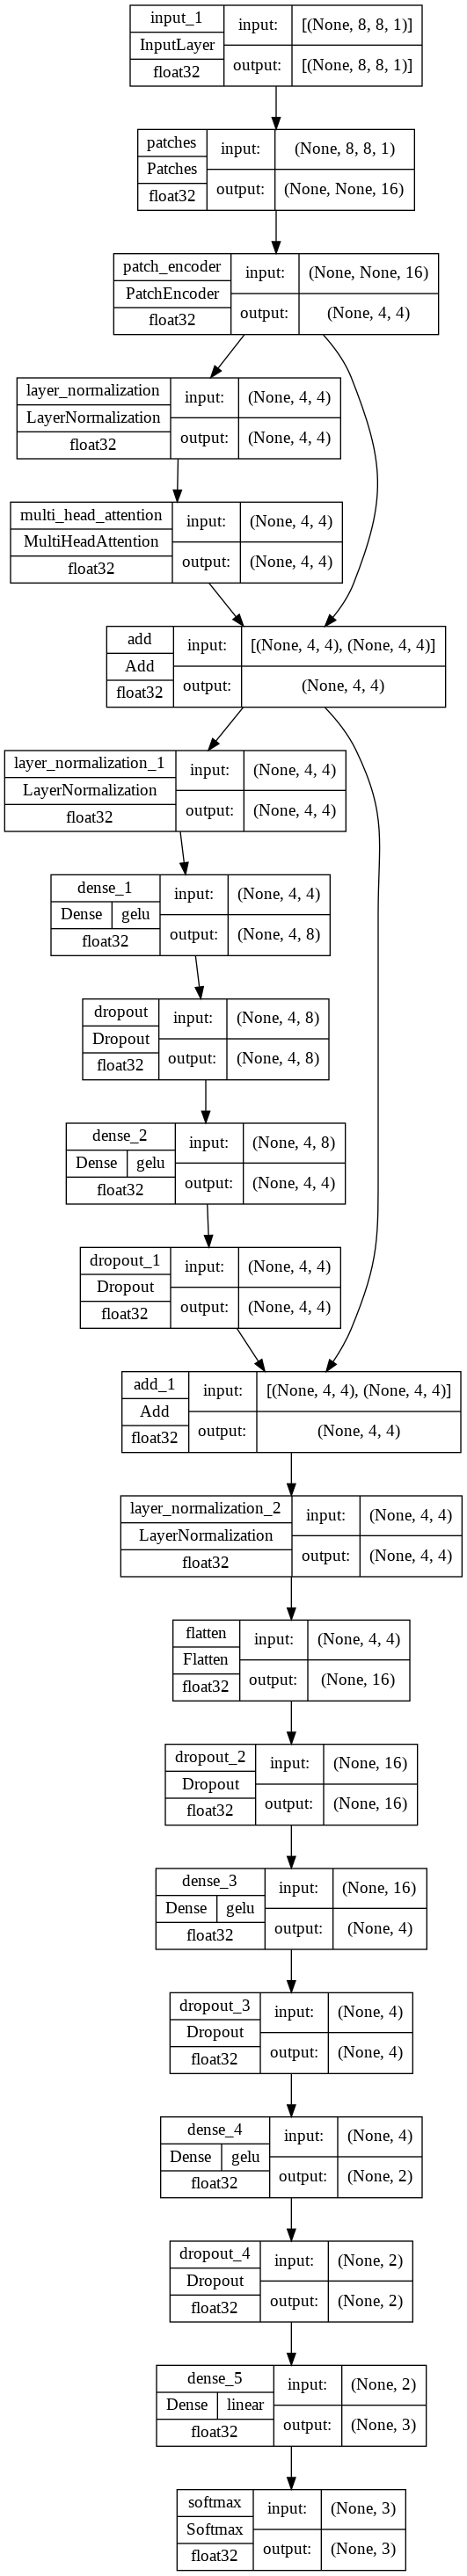

In [ ]:
plot_model(model, to_file = "TheTransformer.png", show_shapes = True, show_layer_names = True, show_dtype = True, show_layer_activations = True)

## Training

In [ ]:
model.fit(x=img, y=y, batch_size=batch_size, epochs=5,)

Epoch 1/5

The patches:

Original Form
 [[[157 162 152 167 138 157 136 137 135 128 87 59 123 128 99 22]
  [168 157 148 136 123 128 126 119 101 112 123 137 70 113 107 106]
  [115 116 167 29 90 93 113 136 112 116 123 111 137 129 132 128]
  [31 57 112 122 91 35 58 87 108 89 105 116 127 112 112 132]]

 [[69 72 70 72 63 96 71 70 44 158 37 34 37 52 165 106]
  [71 70 70 69 71 70 69 68 38 41 37 39 54 131 35 34]
  [38 41 178 181 77 79 167 160 86 113 134 55 88 97 110 91]
  [181 167 63 33 169 43 77 76 157 85 87 85 127 120 95 94]]

 [[38 33 211 233 195 8 83 153 235 161 12 72 235 232 9 104]
  [235 234 234 233 235 234 228 237 233 227 235 195 127 216 221 226]
  [238 234 87 197 216 93 183 147 237 198 134 219 233 215 196 221]
  [118 130 222 202 18 54 191 217 206 14 134 228 214 201 24 229]]]

Image 1
Patch 1
[157 162 152 167 138 157 136 137 135 128 87 59 123 128 99 22]
Patch 2
[168 157 148 136 123 128 126 119 101 112 123 137 70 113 107 106]
Patch 3
[115 116 167 29 90 93 113 136 112 116 123 111 137 129 1

## Testing

In [ ]:
predictions = model.predict(img)
tf.print("Predictions:\n", predictions, summarize = -1)


The patches:

Original Form
 [[[69 72 70 72 63 96 71 70 44 158 37 34 37 52 165 106]
  [71 70 70 69 71 70 69 68 38 41 37 39 54 131 35 34]
  [38 41 178 181 77 79 167 160 86 113 134 55 88 97 110 91]
  [181 167 63 33 169 43 77 76 157 85 87 85 127 120 95 94]]

 [[157 162 152 167 138 157 136 137 135 128 87 59 123 128 99 22]
  [168 157 148 136 123 128 126 119 101 112 123 137 70 113 107 106]
  [115 116 167 29 90 93 113 136 112 116 123 111 137 129 132 128]
  [31 57 112 122 91 35 58 87 108 89 105 116 127 112 112 132]]

 [[38 33 211 233 195 8 83 153 235 161 12 72 235 232 9 104]
  [235 234 234 233 235 234 228 237 233 227 235 195 127 216 221 226]
  [238 234 87 197 216 93 183 147 237 198 134 219 233 215 196 221]
  [118 130 222 202 18 54 191 217 206 14 134 228 214 201 24 229]]]

Image 1
Patch 1
[69 72 70 72 63 96 71 70 44 158 37 34 37 52 165 106]
Patch 2
[71 70 70 69 71 70 69 68 38 41 37 39 54 131 35 34]
Patch 3
[38 41 178 181 77 79 167 160 86 113 134 55 88 97 110 91]
Patch 4
[181 167 63 33 169 43 7

In [ ]:
print("Predicting Using The Logits\n")
for i, prediction in enumerate(predictions):
  predicted_index = np.argmax(prediction)
  print(f'Predicted on Image {i+1}: {labels[predicted_index]}')

Predicting Using The Logits

Predicted on Image 1: Bird
Predicted on Image 2: Dog
Predicted on Image 3: Dog
